In [1]:
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary

In [2]:
# Load the Fashion MNIST dataset using torchvision
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))
])
transform = transforms.ToTensor()
mnist_data = datasets.MNIST(root='./data',
                            train=True, transform=transform,download=True)
data_loader = torch.utils.data.DataLoader(mnist_data,batch_size=64,shuffle=True)

dataiter = iter(data_loader)
images, labels = next(dataiter)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 137922297.89it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 24422518.92it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 17619252.56it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4131539.53it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
       nn.Conv2d(1,16,3,stride=2,padding=1), # N,16, 14,14
       nn.ReLU(),
       nn.Conv2d(16,32,3,stride=2,padding=1), # N, 32,7,7
       nn.ReLU(),
       nn.Conv2d(32,64,7), # N, 64,1,1
       nn.ReLU(),
       nn.Flatten(),
       nn.Linear(64,2)

    )
    self.decoder = nn.Sequential(
        nn.Linear(2,64), # N,64,1,1
        nn.Unflatten(1,(64,1,1)),
        nn.ConvTranspose2d(64,32,7), # N,32,7,7
        nn.ReLU(),
        nn.ConvTranspose2d(32,16,3,stride=2,padding=1,output_padding=1), # N,16,14,14
        nn.ReLU(),
        nn.ConvTranspose2d(16,1,3,stride=2,padding=1,output_padding=1), # N,1,28,28
        nn.Sigmoid()

    )
  def forward(self,x):
    if x.shape[-1]>2:
      x = x.view(-1,1,28,28)
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return encoded, decoded
    else:
      decoded = self.decoder(x)
      return  decoded

    return decoded


# Defining the Training Loop

In [4]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
labels = []
images = []
for data in mnist_data:
    image, label = data
    images.append(image)
    labels.append(label)

# Convert lists to tensors after the loop
images_tensor = torch.stack(images).to(device)
labels_tensor = torch.tensor(labels).to(device)


In [ ]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

num_epochs=20
outputs=[]
for epoch in range(num_epochs):
  for (img,_) in data_loader:
    optimizer.zero_grad()
    embeddings, reconstruction = model(img)
    loss = criterion(reconstruction, img)
    loss.backward()
    optimizer.step()
  outputs.append((epoch, img, embeddings, reconstruction))
  print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')

# save model parameters
save_path=r'/content/drive/MyDrive/model_params/autoencoder_cnn.pt'
torch.save(model.state_dict(), save_path)


In [7]:
import pickle

# Save the list of tensors to a file
with open(r'/content/drive/MyDrive/model_params/outputs.pkl', 'wb') as file:
    pickle.dump(outputs, file)

## Visualize Latent Space

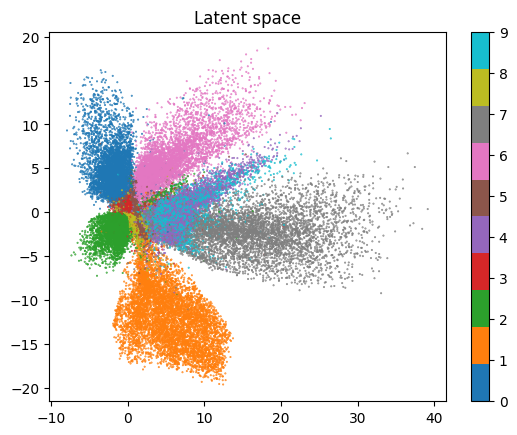

In [14]:
model=Autoencoder()

save_path=r'/content/drive/MyDrive/model_params/autoencoder_cnn.pt'
model.load_state_dict(torch.load(save_path))
model.eval()
with torch.no_grad():
 embeddings, reconstruction = model(images_tensor)

# scatter plot of embedding
plt.scatter(embeddings[:,0],embeddings[:,1],c=labels_tensor,cmap='tab10',s=0.2)
plt.colorbar()
plt.title('Latent space')
plt.show()

## Generating new images

In [23]:
# Create new random data with dimensions same as 'Latent Space'
embeddings_flat = embeddings.view(-1)

# Calculate the minimum and maximum values
min_val = embeddings_flat.min().item()
max_val = embeddings_flat.max().item()

# Generate a sample tensor of random numbers between min_val and max_val with shape (18, 2)
sample_tensor = torch.empty(18, 2).uniform_(min_val, max_val)

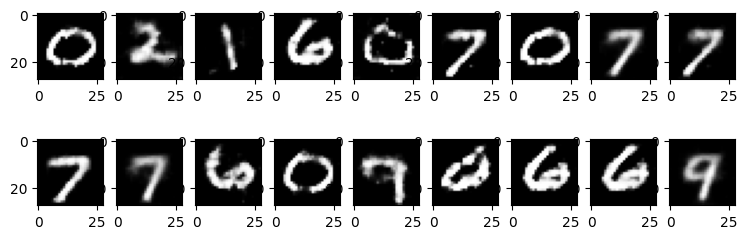

In [24]:
# generate images
model=Autoencoder()
model.load_state_dict(torch.load(save_path))
model.eval()
with torch.no_grad():
  outputs = model(sample_tensor)

plt.figure(figsize=(9,3))
plt.gray()
for i in range(18):
  plt.subplot(2,9,i+1)
  plt.imshow(outputs[i].reshape(28,28,-1))